In [1]:
# import packages for data wranging and plotting 
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud

# import packages for Feature Engineering 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from leven import levenshtein 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.ensemble import RandomForestRegressor
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string
import gc
import re, math
from collections import Counter
from sklearn import preprocessing
from sklearn import utils
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#read all data
print('Reading data...')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print('Reading data completed')

targets = list(sample_submission.columns[1:])
input_columns = ['question_title', 'question_body', 'answer']

Reading data...
Reading data completed


# Get a glimpse of the data

In [3]:
train_data[targets].describe()

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,0.892663,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,0.004469,...,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,0.132047,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,0.045782,...,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,0.777778,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,0.000000,...,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,0.888889,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,0.000000,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,0.000000,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#let's see if there is some missing data
def percent_missing_values(data):
    percent_missing = data.isnull().sum() * 100 / len(data)
    percent_df = pd.DataFrame({'columns':data.columns,'percent missing':percent_missing})
    percent_df.sort_values('percent missing',inplace=True)
    return percent_df.reset_index(drop = True)

#Missing data for test_data
percent_missing_values(test_data)

,columns,percent missing
0,qa_id,0.0
1,question_title,0.0
2,question_body,0.0
3,question_user_name,0.0
4,question_user_page,0.0
5,answer,0.0
6,answer_user_name,0.0
7,answer_user_page,0.0
8,url,0.0
9,category,0.0


In [5]:
#Missing data for train_data
percent_missing_values(train_data)

,columns,percent missing
0,qa_id,0.0
1,question_type_choice,0.0
2,question_type_compare,0.0
3,question_type_consequence,0.0
4,question_type_definition,0.0
5,question_type_entity,0.0
6,question_type_instructions,0.0
7,question_type_procedure,0.0
8,question_type_reason_explanation,0.0
9,question_type_spelling,0.0


In [6]:
#define function to plot different diagrams
def distribution_plot(data,column,top_v=None,alpha = 0.4,type='barplot'):
    #Forge data for further manipulations with counts
    count_data = data[column].value_counts()
    if top_v is not None:
        count_data = count_data[:top_v,]
    if type == 'barplot':
        #just show percent of data for each category
        values_p = count_data.values * 100 / sum(count_data.values)
        sns.barplot(count_data.index,values_p , alpha = alpha)
    else:
        #draw pie with values 
        plt.pie(count_data.values,labels=count_data.index)
        
        #draw inner circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

Text(0.5,0,'category')

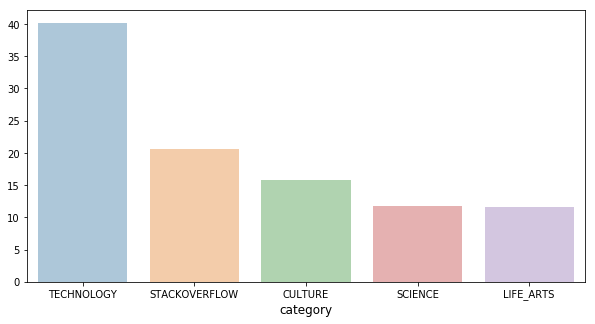

In [7]:
plt.figure(figsize=(10,5))
distribution_plot(train_data,'category')
plt.xlabel('category',fontsize=12)

Text(0.5,0,'host')

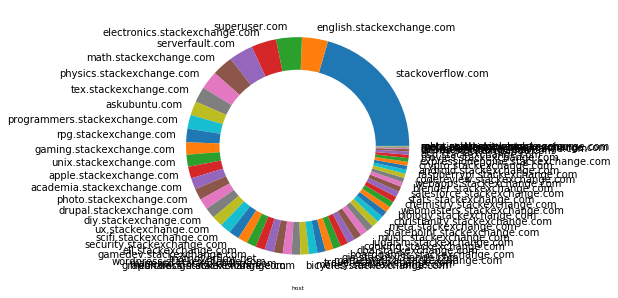

In [8]:
plt.figure(figsize=(5,5))
distribution_plot(train_data,'host',type='x')
plt.xlabel('host',fontsize=6)

## Distribution of all target features

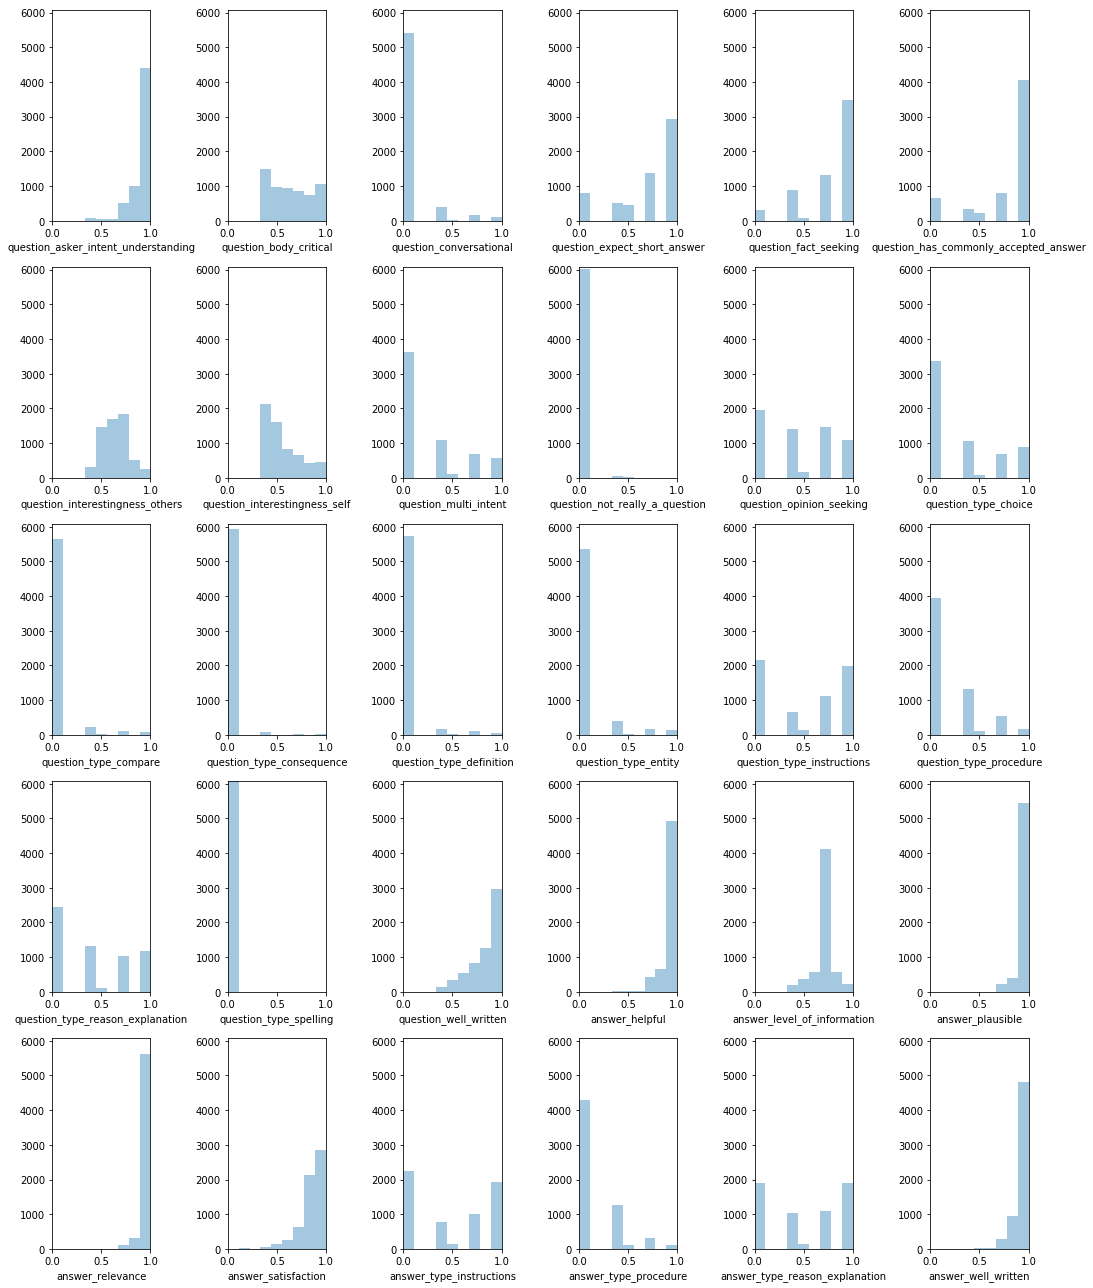

In [9]:
grid = gridspec.GridSpec(5,6)
plt.figure(figsize=(15,18))
bins = np.linspace(0, 1, 10)
#plot every column
for i,col in enumerate(targets):
    ax = plt.subplot(grid[i])
    sns.distplot(train_data[col] , label = col, kde = False , bins = bins)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)
plt.tight_layout()
plt.show()

In [48]:
#Function to plot distribution of char and word counts
def compare_train_test(column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    #Count count of chars in test and train data
    counts_c_train = train_data[column].apply(len)
    counts_c_test = test_data[column].apply(len)
    
    #Count count of words in test and train data
    counts_word_train = train_data[column].apply(word_count)
    counts_word_test = test_data[column].apply(word_count)
    
    #plot first couple of distributions
    sns.distplot(counts_c_train,label='train',kde=True,ax = axes[0])
    sns.distplot(counts_c_test,label='test',kde=True,ax = axes[0])
    axes[0].legend()
    
    #plot second couple of distributions
    sns.distplot(counts_word_train,label='train',kde=True,ax = axes[1])
    sns.distplot(counts_word_test,label='test',kde=True,ax = axes[1])    
    axes[1].legend()
    plt.show()

#calculate words' count in the string
def word_count(s):
    return s.count(' ')

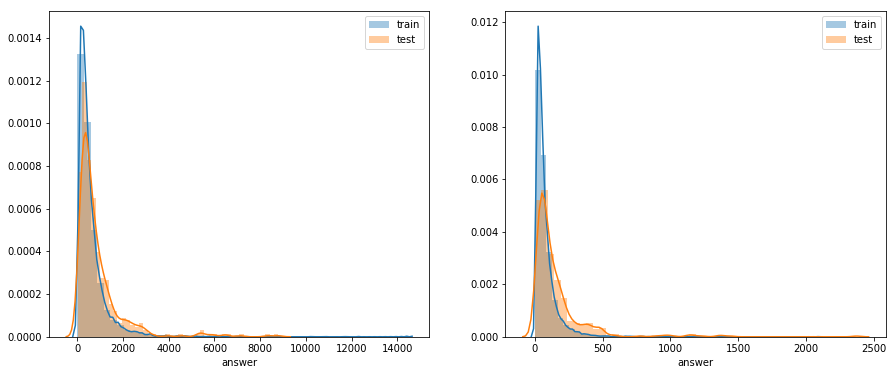

In [49]:
compare_train_test('answer')

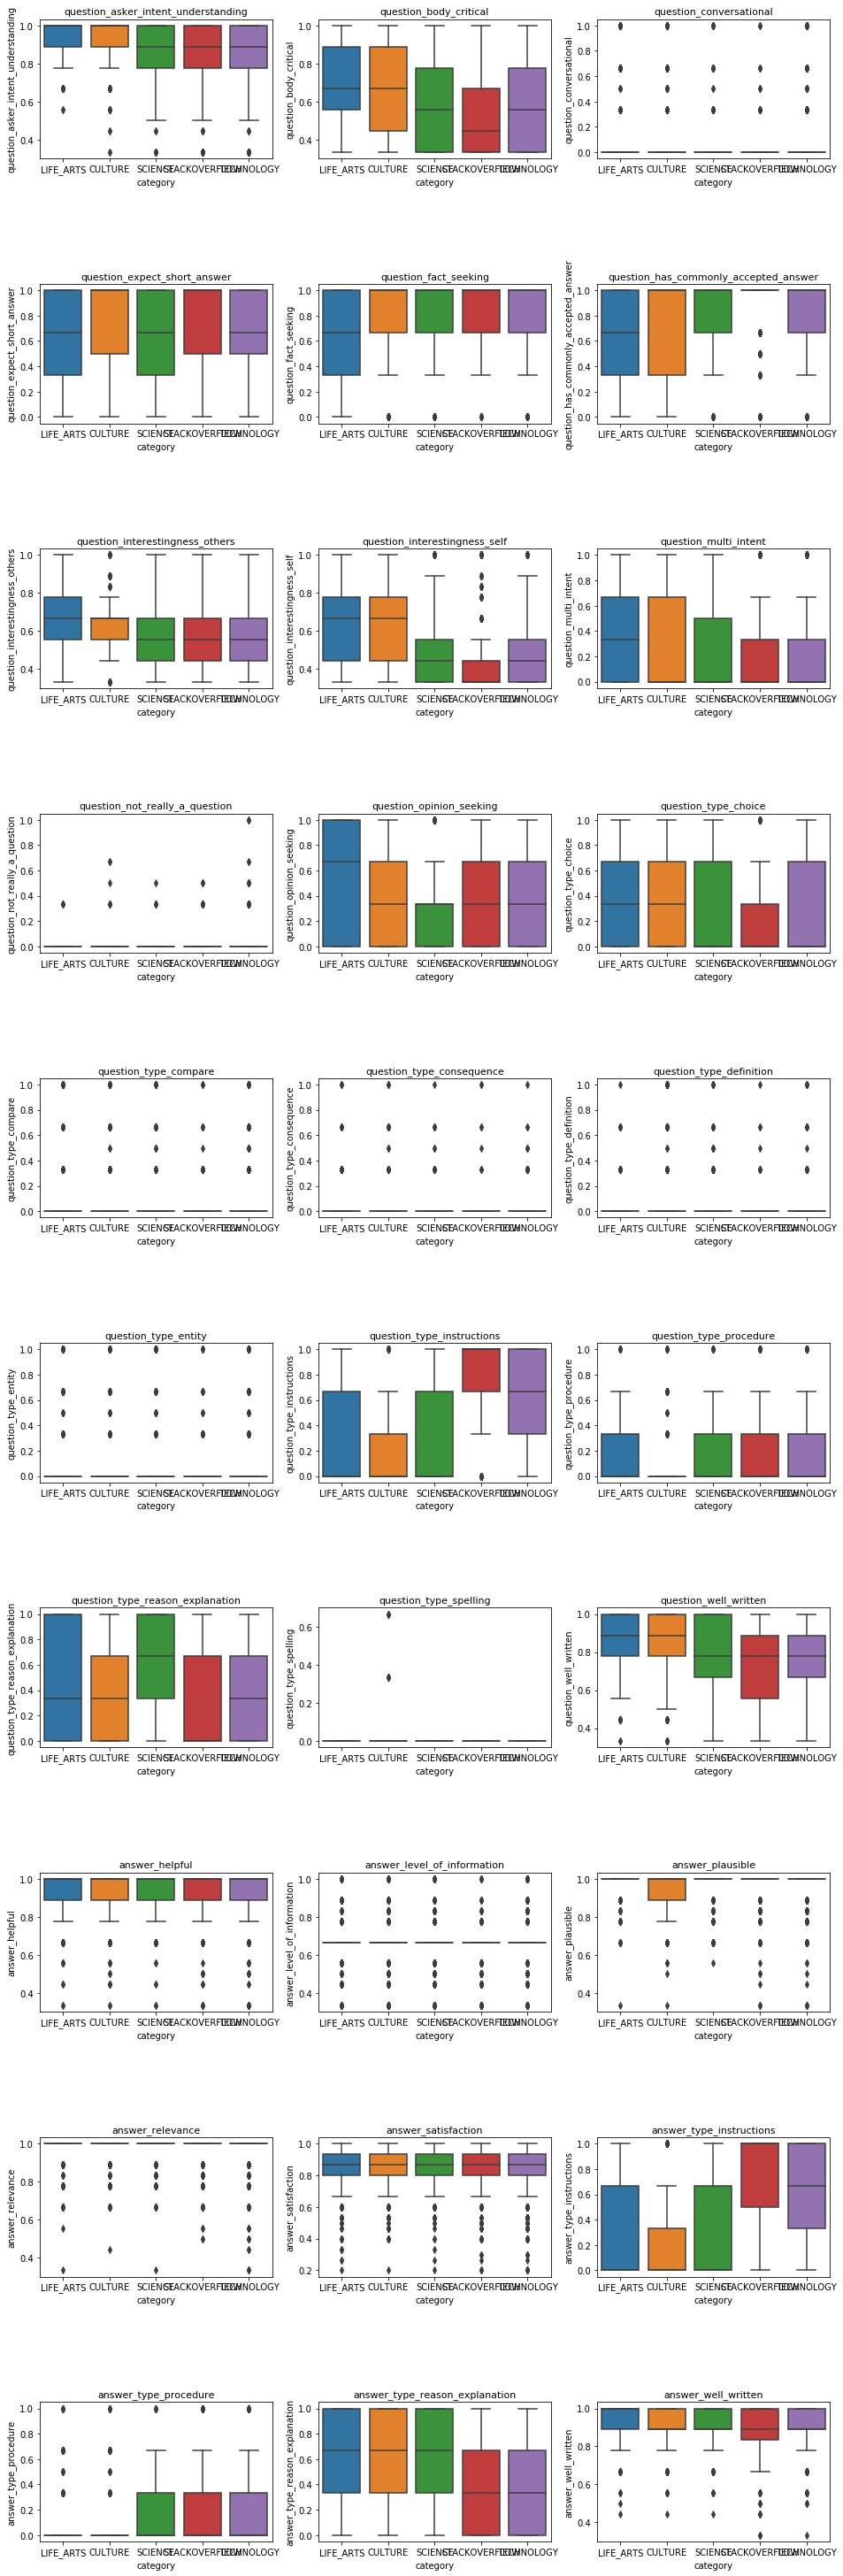

In [10]:
#define function for plotting some columns

def distribution_columns(columns,by_column,count_row = 3):
    plt.figure(figsize=(16,12*4))
    
    #calculate number of rows for plotting
    cnt_columns = math.ceil(len(columns) / count_row )
    grid = gridspec.GridSpec(cnt_columns,count_row)
    count = 0
    
    #plot every column
    for i,col in enumerate(columns):
        ax = plt.subplot(grid[count])
        sns.boxplot(x = by_column,y = col, data = train_data)
        ax.set_title(str(col),fontsize = 11)
        count += 1
    plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)
    plt.show()
distribution_columns(targets,'category')

__In the case below it's hard to plot by host and thereby to pinpoint some facts, however we can notice that there are more than marginal differences between hosts' distributions__

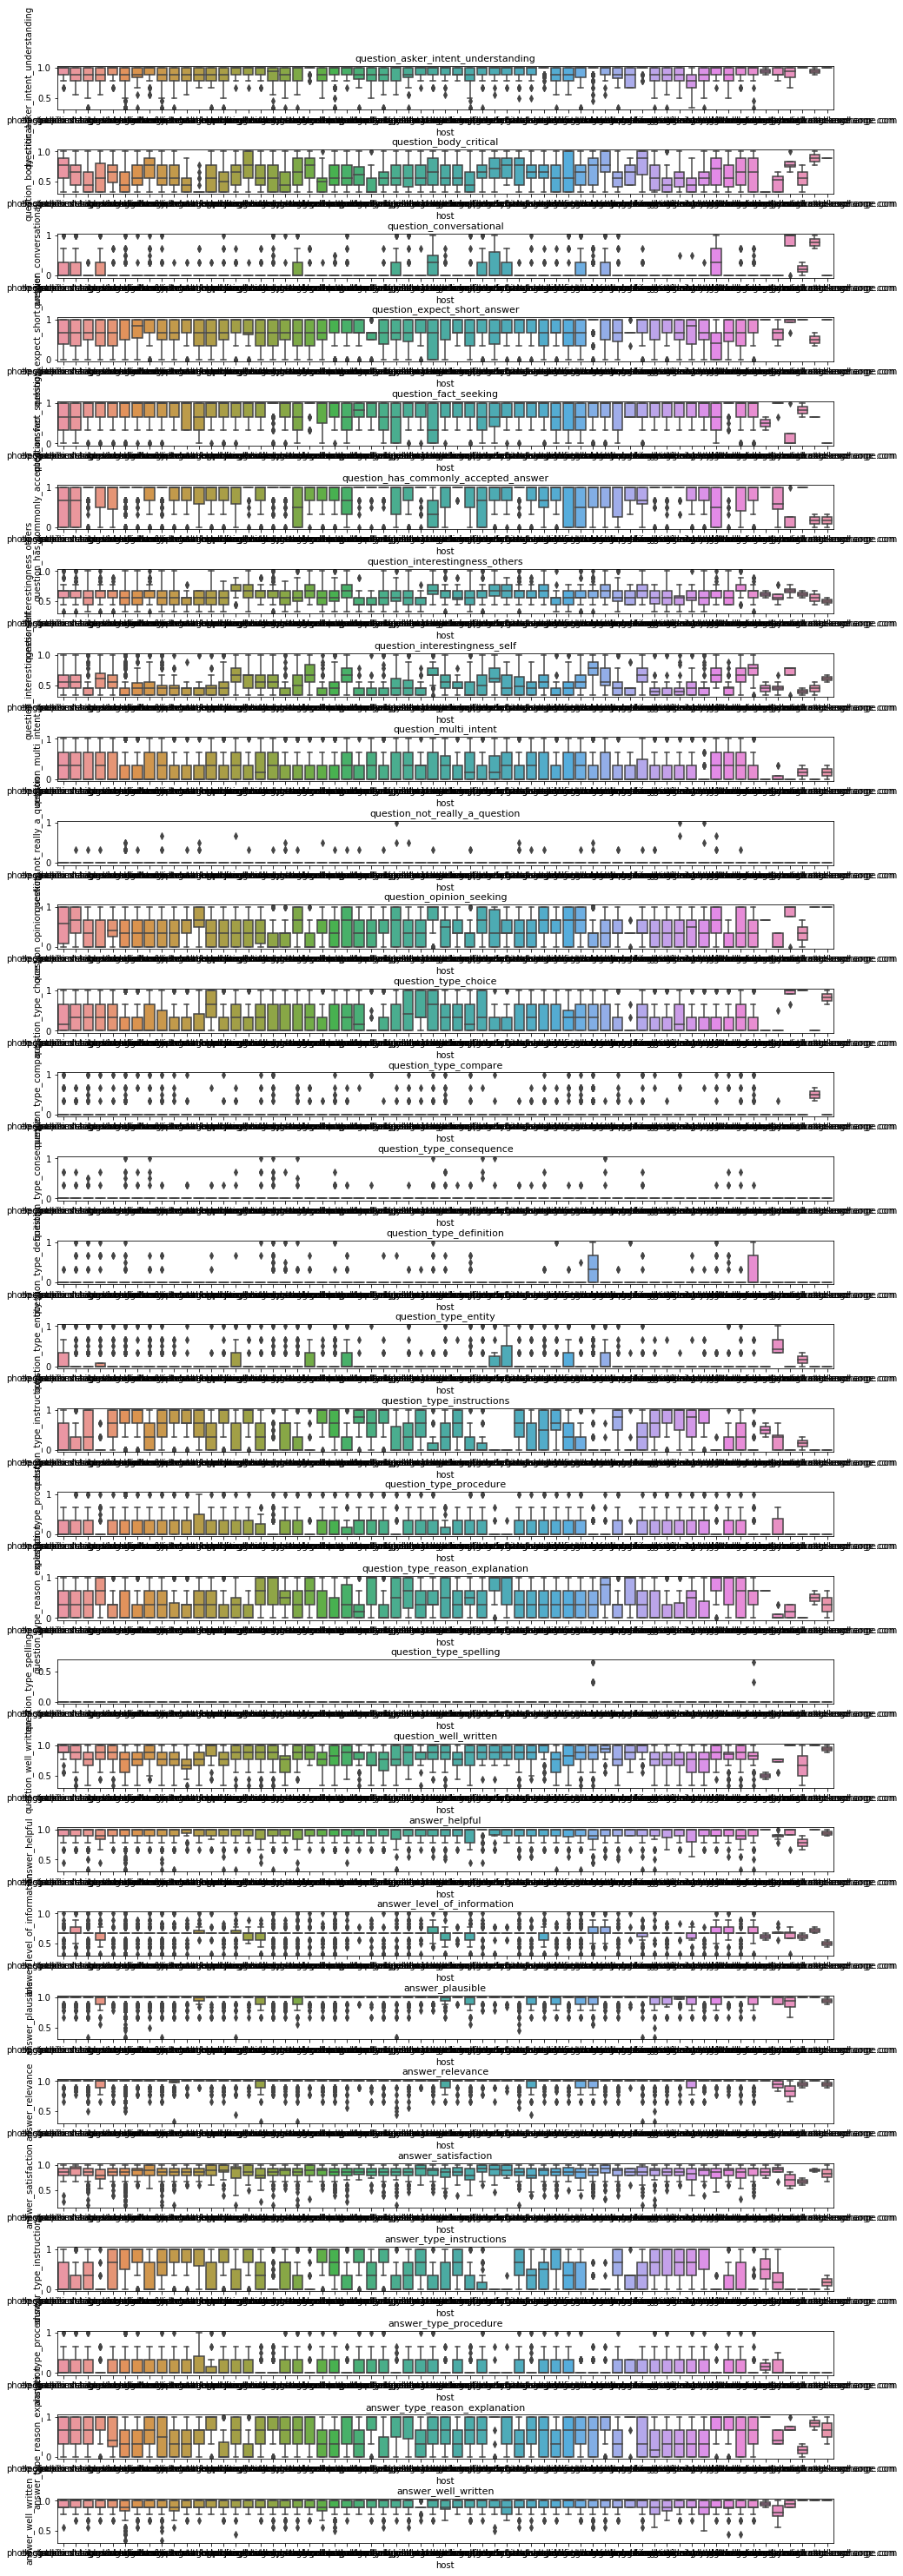

In [11]:
distribution_columns(targets,'host',1)

### HeatMap for correlations

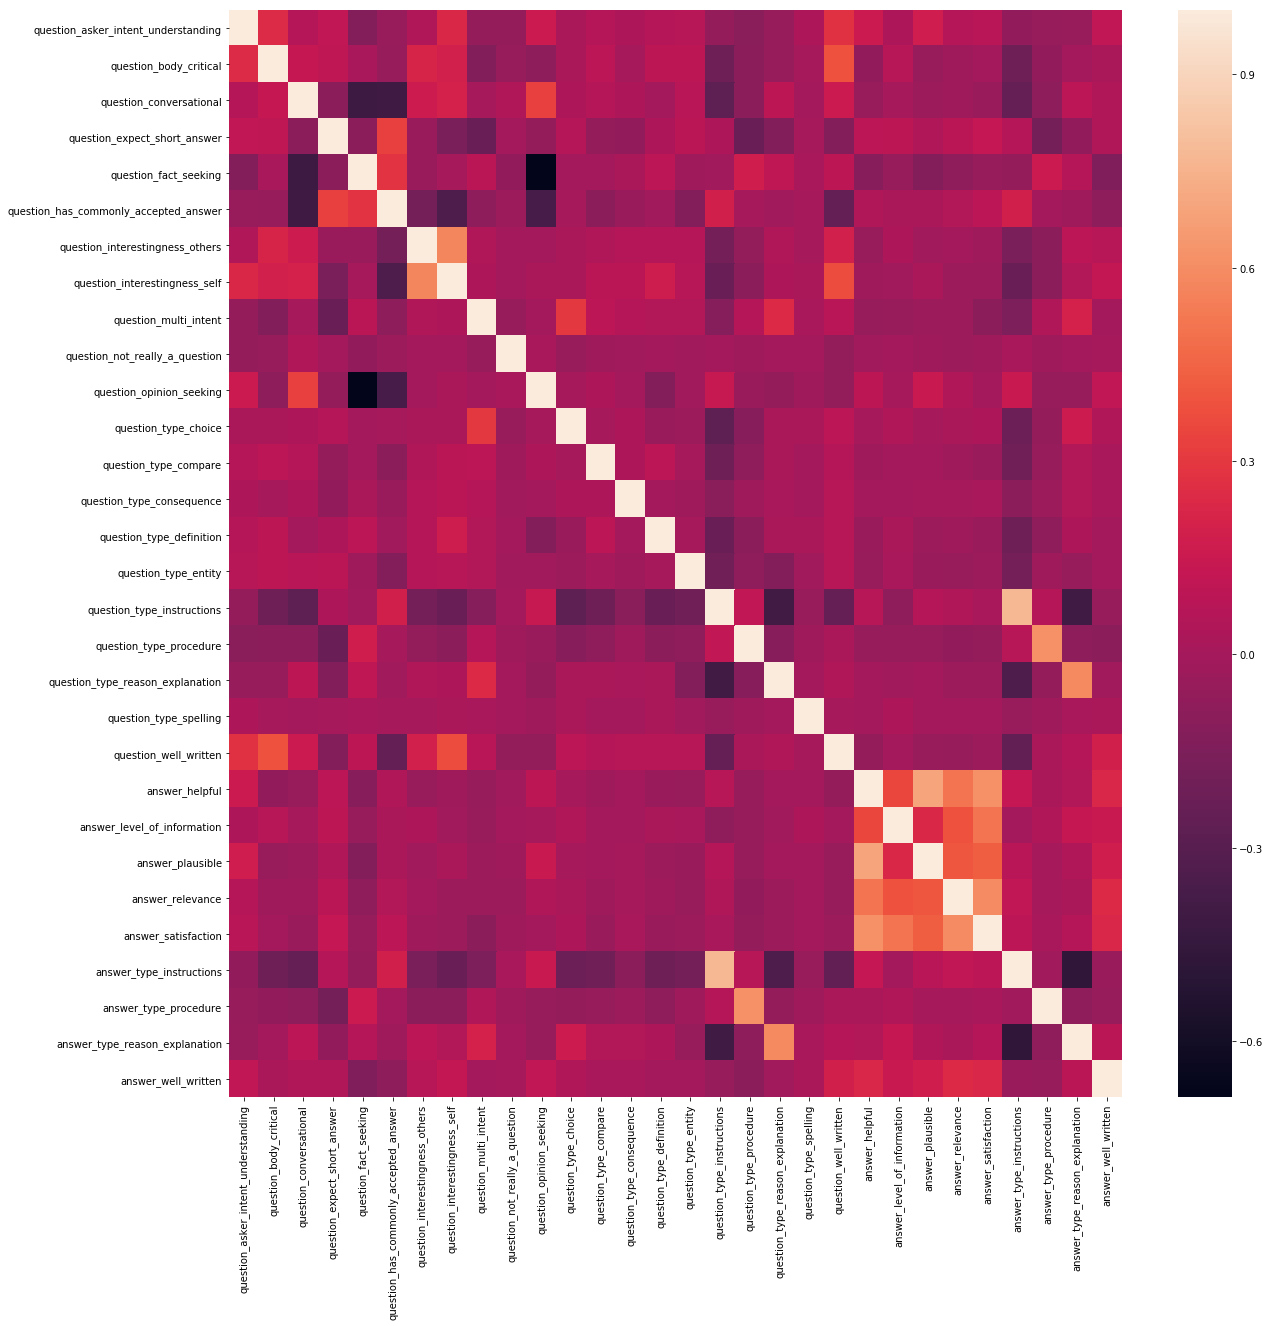

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_data[targets].corr())

In [13]:
#define function to plot word counts
def plot_word_counts(data,top_n,*columns):
    grid = gridspec.GridSpec(math.ceil(len(columns) / 2),len(columns))
    count_c = len(columns)
    count = 0
    
    #We only need here three plots at most 
    if len(columns) > 3:
        raise NameError('Too many columns')
    f = plt.figure(figsize=(18,3))
    
    #iterate over columns
    for col in columns:
        
        #create space for plot
        ax = plt.subplot(grid[count])
        count += 1
        
        #Divide sentences to words
        freq_dist = [word for text in data[col] for word in text.split()]
        
        #Delete stop words 
        stop_words = set(stopwords.words('english'))
        stop_words.update(['=','{','}','-','The','//'])
        freq_dist = [word for word in freq_dist if word not in stop_words]
        
        #Create data with counts of words
        freq_dist_f = Counter(freq_dist)
        df_freq = pd.DataFrame.from_dict(freq_dist_f,orient='index')
        df_freq.sort_values(0,ascending=False,inplace=True)
        df_freq = df_freq.iloc[:top_n,0]
        sns.barplot(x=df_freq.index,y=df_freq.values,palette="BuGn_r")
        ax.set_title(col)
    plt.show()

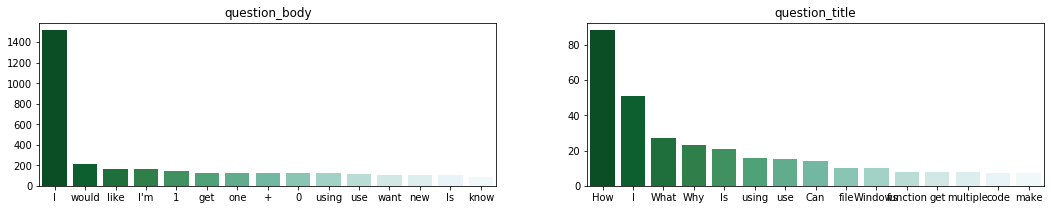

In [14]:
plot_word_counts(test_data,15,'question_body','question_title')

__Wordclouds by category__

In [15]:
#define function to plot wordClouds
def plot_wordclouts(column_groupby,column_to_plot):
    grid = gridspec.GridSpec(5,2)
    plt.figure(figsize=(16,7*4))
    
    #Delete stop words 
    stop_words_plot = set(stopwords.words('english'))
    stop_words_plot.update(['=','{','}','-','The','//','would','could'])
    
    #Iterate over unique values of chosen column
    for i,val_col in enumerate(train_data[column_groupby].value_counts().index):
        #Clean data
        clean_data(train_data,column_to_plot)
        
        #Create list of words
        texts = " ".join(train_data[train_data[column_groupby] == val_col ][column_to_plot].astype(str))
        
        #Plot wordCloud
        wordcloud = WordCloud(
            background_color='black',
            max_words=150,
            max_font_size=90,
            random_state=21).generate(texts)
        plt.imshow(wordcloud)
        plt.title(f"Category: {val_col}",fontsize=18)
        plt.axis('off')
        plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )
        plt.show()
#Clean data
def clean_data(data,col):
    
    #Lower case and split
    data[col]=data[col].str.lower().str.split()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['=','{','}','-','the','//'])
    
    #stay only words not in stop list
    data[col] = data[col].apply(lambda x: [word for word in x if word not in stop_words])
    data[col] = data[col].str.join(" ")

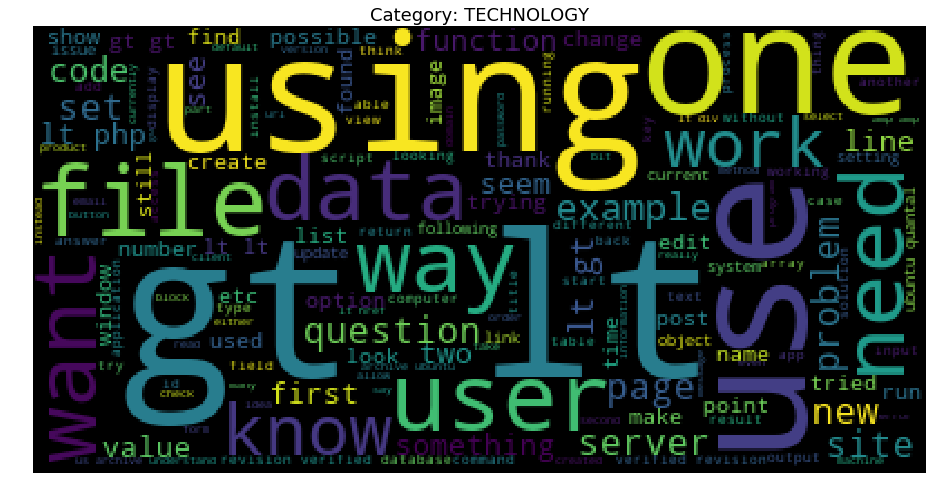

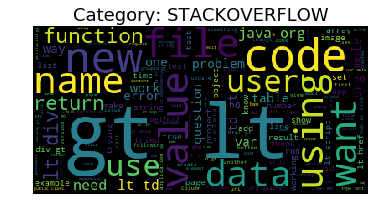

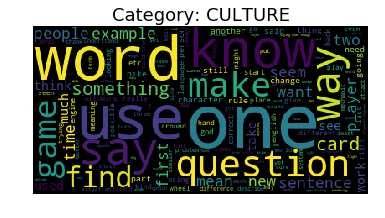

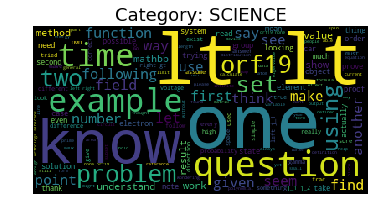

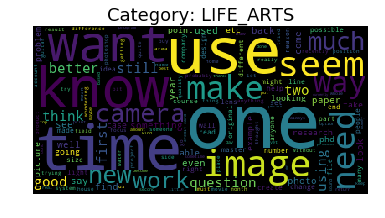

In [16]:
#For questions
plot_wordclouts('category','question_body')

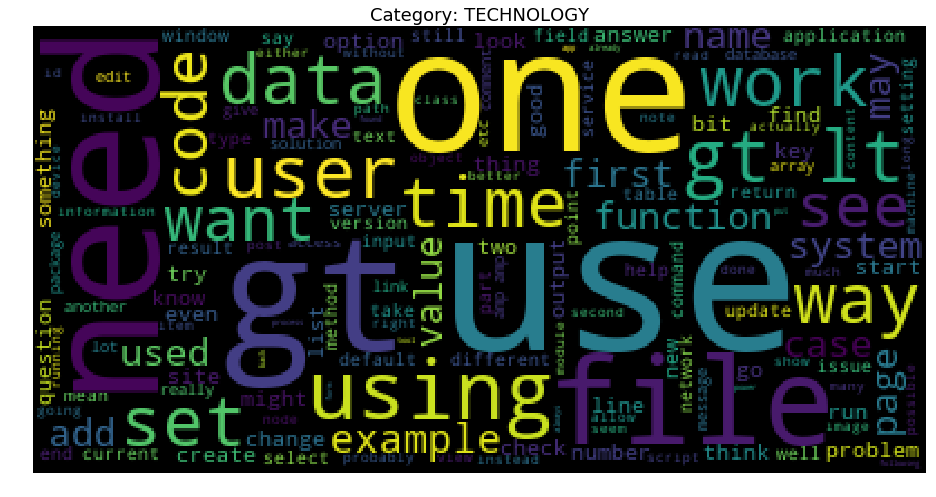

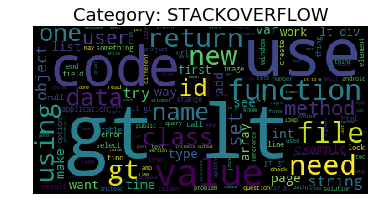

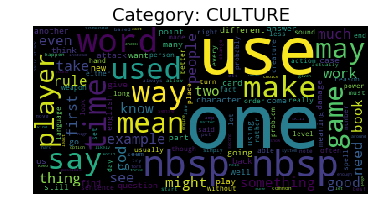

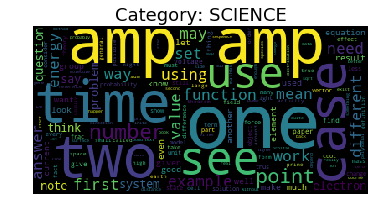

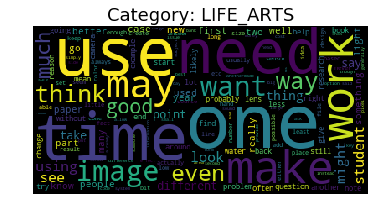

In [17]:
#For answering
plot_wordclouts('category','answer')

In [18]:
#Time is coming to create some new features
def forge_features(data_train,data_test,*columns):
    
    #We should join them and add new column that will help us to distinquish two data sets
    data_train['train_test'] = 1
    data_test['train_test'] = 0
    data = pd.concat([data_train,data_test])
    #Reset indexes 
    data = data.reset_index(drop=True)
    
    #Create TF-IDF model and SVD model to manage this data in lower dimensional space
    tfIdf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),max_features=80000)
    tsvd = TruncatedSVD(n_components = 64, n_iter=5)
    
    #iterate over columns
    for col in columns:
        print('Starting to work with ' + col + ' column...')
        #some preprocessing
        clean_data(data,col)
        
        #Calculate count of sentences , count of words, count of unique words  and count of chars
        data['count_s'+col] = data[col].apply(sent_tokenize).apply(len)
        data['count_w'+col] = data[col].apply(word_tokenize).apply(len)
        data['count_un'+col] = data[col].apply(word_tokenize).apply(pd.unique).apply(len)
        data['count_c'+col] = data[col].apply(len)
        
        #Apply td idf model and transform it in low dimensional space
        fitted_vectorizer = tfIdf.fit(data[col])
        tfidf_vectorizer_vectors = fitted_vectorizer.transform(data[col])
        tsvd_model = tsvd.fit_transform(tfidf_vectorizer_vectors)
        df_tfdata = pd.DataFrame(tsvd_model)
        df_tfdata.columns = ['tsvd'+col+str(column) for column  in df_tfdata.columns]
        
        #concatenate all data above
        data = pd.concat([data, df_tfdata], axis=1, sort=False)
        print(data.shape)
        print('Finished with ' + col+ ' column')
    
    #calculate count rates between question_body,answer and question_title
    data['rate_w'] = data['count_w'+'question_body' ] / data['count_w'+'answer']
    data['rate_c'] = data['count_c'+'question_body' ] / data['count_c'+'answer']
    data['rate_un'] = data['count_un'+'question_body' ] / data['count_un'+'answer']
    #Calculate three types of distances between texts
    
    #Cosine distance
    data['cosine_sim_qba'] = data.apply(lambda x: get_cosine(x['question_body'],x['answer']),axis=1)
    data['cosine_sim_qta'] = data.apply(lambda x: get_cosine(x['question_title'],x['answer']),axis=1)
    data['cosine_sim_qbqt'] = data.apply(lambda x: get_cosine(x['question_body'],x['question_title']),axis=1)
    
    #Euclidean distance
    data['l2_sim_qba'] = data.apply(lambda x: get_l2(x['question_body'],x['answer']),axis=1)
    data['l2_sim_qta'] = data.apply(lambda x: get_l2(x['question_title'],x['answer']),axis=1)
    data['l2_sim_qbqt'] = data.apply(lambda x: get_l2(x['question_body'],x['question_title']),axis=1)
    
    #levenshtein distance
    data['lev_sim_qba'] = data.apply(lambda x: levenshtein(x['question_body'],x['answer']),axis=1)
    data['lev_sim_qta'] = data.apply(lambda x: levenshtein(x['question_title'],x['answer']),axis=1)
    data['lev_sim_qbqt'] = data.apply(lambda x: levenshtein(x['question_body'],x['question_title']),axis=1)
    
    #Check if there is user name mentioned in answer
    data['user_find_answer'] = data.apply(lambda x: exist_user(x['answer'],x['answer_user_name']),axis=1)
    
    #Create dummies for host and category
    dummies_host = pd.get_dummies(data['host'])
    dummies_category = pd.get_dummies(data['category'])
    data = pd.concat([data, dummies_host,dummies_category], axis=1, sort=False)
    
    #Split back to test and train data
    data_train = data[data['train_test']==1]
    data_test = data[data['train_test']==0]
    print('Full finished')
    return data_train,data_test

#Calculate cosine distance
def get_cosine(vector1,vector2):
    
    #transform text to vector of words' counts
    vector1 = text_to_vector(vector1)
    vector2 = text_to_vector(vector2)
    
    #Find intersection in words between two vectors
    intersection = set(vector1.keys()) & set(vector2.keys())
    
    #Calculate distance
    numerator = sum([vector1[x]*vector2[x] for x in intersection])
    sum1 = sum([vector1[x]**2 for x in vector1.keys()])
    sum2 = sum([vector2[x]**2 for x in vector2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
    
#Calculate Euclidean distance
def get_l2(vector1,vector2):
    
    #transform text to vector of words' counts
    vector1 = text_to_vector(vector1)
    vector2 = text_to_vector(vector2)
    
    #Find intersection in words between two vectors
    intersection = set(vector1.keys()) & set(vector2.keys())
    
    #Calculate distance
    multip = sum([vector1[x]*vector2[x] for x in intersection])
    sum1 = sum([vector1[x]**2 for x in vector1.keys()])
    sum2 = sum([vector2[x]**2 for x in vector2.keys()])
    l2 = (sum1 - 2 * multip + sum2)**(0.5)
    return l2

#Transform text to vector of words' counts
def text_to_vector(text):
    WORD = re.compile(r'\w+')
    words = WORD.findall(text)
    return Counter(words)

#Find phrase or word in text 
def exist_user(text,find):
     if find.lower() in text.lower():
        return 1 
     else:
        return 0


In [58]:
# Creating features
tt,tt_test = forge_features(train_data[test_data.columns],test_data,'question_body','question_title','answer')

c:\users\marik\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Full finished


In [118]:
#we should get rid of all columns we don't need to apply to the model
try:
    data = tt.drop(input_columns, axis=1, inplace=False)
    data = data.drop(['qa_id','host','question_user_name','question_user_page','answer_user_name','answer_user_page','url','category','train_test'], axis=1, inplace=False)
except:
    print('Already done')
try:
    tt_test = tt_test.drop(['qa_id','host','question_user_name','question_user_page','answer_user_name','answer_user_page','url','category','train_test'], axis=1, inplace=False)
    tt_test = tt_test.drop(input_columns, axis=1, inplace=False)
except:
    print('Something wrong with columns')
    
#Scaling data    
data,tt_test = transform(data,tt_test)
data_target = train_data[targets]
val_pred = []
train_pred = []

submission = pd.DataFrame.from_dict({'qa_id': test_data['qa_id']})
#test_1 = np.zeros((train_features_1.shape[0], ))
#spearman_scores = []
#targets = list(sample_submission.columns[1:])


#RandomForest Regressor
model = RandomForestRegressor()
param_grid = {
    'bootstrap': [True],
    'max_depth': [90,110],
    'max_features': [120,130],
    'min_samples_leaf': [3],
    'min_samples_split': [6],
    'n_estimators': [2400]
}

n_splits = 3

#Apply grid search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = n_splits, n_jobs = -1, verbose = 2)
grid_search.fit(data, data_target)
print('Final scores')
print(grid_search.best_params_)
best = grid_search.best_params_

#Predict test variables
test_pred = grid_search.predict(tt_test)

#Just to adjust our values to reality
test_pred[test_pred > 1] = 1
test_pred[test_pred < 0] = 0

#Collect our submission
submission = pd.DataFrame(test_pred,columns=data_target.columns)
del test_pred
gc.collect()
submission['qa_id']=test_data['qa_id'].astype('int')
cols = submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

#Final submission
submission.to_csv('submission.csv',index=False)

#Normalize data
def transform(data1,data2):
    columns = data1.columns
    
    #Join two frames together
    result = pd.concat([data1,data2])
    
    #Apply just Min Max scaler
    scaler = MinMaxScaler()
    scaler.fit(result) 
    data1 = scaler.transform(data1)
    data2 = scaler.transform(data2)
    
    #Split it back to two dataframes
    data1 = pd.DataFrame(data1,columns = columns)
    data2 = pd.DataFrame(data2,columns = columns)
    return data1,data2

Already done
Something wrong with columns


NameError: name 'transform' is not defined